# 🌿 Plant Disease Classification Pipeline

This notebook provides a complete ML pipeline for plant disease classification using the PlantVillage dataset with ResNet50 transfer learning.

**Run on Google Colab for faster GPU training!**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-repo/plant-disease-classification/blob/main/notebook/plant_disease_classification.ipynb)

## Contents
1. Setup & Configuration
2. Mount Google Drive (for Colab)
3. Dataset Preparation
4. Data Exploration & Visualization
5. Model Training with ResNet50
6. Model Evaluation
7. Prediction Demo
8. Export Model

## 1. Setup & Configuration

First, let's install required packages and configure the environment.

In [1]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Running on Google Colab!")
    # Install required packages
    !pip install -q tensorflow matplotlib seaborn scikit-learn pillow tqdm
else:
    print("💻 Running locally")

# Check GPU availability
import tensorflow as tf
print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

💻 Running locally


2025-11-26 18:43:10.692841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



TensorFlow version: 2.16.2
GPU available: False


In [2]:
# Import all required libraries
import os
import json
import shutil
import random
import datetime
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
)
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
FINE_TUNE_EPOCHS = 15
FINE_TUNE_LR = 0.0001
RANDOM_SEED = 42

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Mount Google Drive & Download Dataset

For Colab: Mount your Google Drive to save models and access the dataset.

**Option A:** Upload the PlantVillage dataset to your Google Drive
**Option B:** Download directly from Kaggle (requires Kaggle API key)

In [3]:
# Setup paths based on environment
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Set base directory in Google Drive
    BASE_DIR = Path('/content/drive/MyDrive/ml-pipeline')
    BASE_DIR.mkdir(parents=True, exist_ok=True)
    
    # You can also work in /content for faster I/O (but data won't persist)
    WORK_DIR = Path('/content/plant_disease')
    WORK_DIR.mkdir(parents=True, exist_ok=True)
else:
    # Local paths
    BASE_DIR = Path('../')
    WORK_DIR = BASE_DIR

# Define paths
DATA_DIR = WORK_DIR / 'data'
TRAIN_DIR = DATA_DIR / 'train'
VAL_DIR = DATA_DIR / 'val'
TEST_DIR = DATA_DIR / 'test'
MODELS_DIR = WORK_DIR / 'models'
LOGS_DIR = WORK_DIR / 'logs'

# Create directories
for d in [DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, MODELS_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📁 Base directory: {BASE_DIR}")
print(f"📁 Working directory: {WORK_DIR}")
print(f"📁 Data directory: {DATA_DIR}")

📁 Base directory: ..
📁 Working directory: ..
📁 Data directory: ../data


In [4]:
# Download PlantVillage dataset (for Colab)
# Option 1: From Kaggle (recommended)
if IN_COLAB:
    # Check if dataset already exists
    DATASET_DIR = WORK_DIR / 'plantvillagedataset'
    
    if not DATASET_DIR.exists() or not any(DATASET_DIR.iterdir()):
        print("📥 Downloading PlantVillage dataset...")
        
        # Method 1: Using Kaggle API (you need to upload kaggle.json)
        # !pip install -q kaggle
        # !mkdir -p ~/.kaggle
        # !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
        # !chmod 600 ~/.kaggle/kaggle.json
        # !kaggle datasets download -d emmarex/plantdisease -p /content
        # !unzip -q /content/plantdisease.zip -d /content/plant_disease/
        
        # Method 2: Direct download from a mirror (if available)
        # Alternative: Upload your plantvillagedataset folder to Google Drive
        
        print("⚠️ Please upload your PlantVillage dataset to Google Drive at:")
        print(f"   {BASE_DIR / 'plantvillagedataset'}")
        print("\nOr uncomment the Kaggle download code above and add your kaggle.json")
    else:
        print(f"✅ Dataset found at {DATASET_DIR}")
        print(f"   Classes: {len(list(DATASET_DIR.iterdir()))}")
else:
    # Local dataset path
    DATASET_DIR = BASE_DIR / 'plantvillagedataset'
    print(f"📁 Dataset directory: {DATASET_DIR}")
    if DATASET_DIR.exists():
        print(f"   Classes: {len([d for d in DATASET_DIR.iterdir() if d.is_dir()])}")

📁 Dataset directory: ../plantvillagedataset
   Classes: 38


## 3. Dataset Preparation

Split the dataset into train/validation/test sets (70%/15%/15%).

In [5]:
def split_dataset(
    source_dir: Path,
    train_dir: Path,
    val_dir: Path, 
    test_dir: Path,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    force_resplit: bool = False
) -> Dict[str, int]:
    """Split dataset into train/val/test sets."""
    
    # Check if already split
    if not force_resplit and train_dir.exists() and any(train_dir.iterdir()):
        train_count = sum(len(list(d.glob('*'))) for d in train_dir.iterdir() if d.is_dir())
        val_count = sum(len(list(d.glob('*'))) for d in val_dir.iterdir() if d.is_dir())
        test_count = sum(len(list(d.glob('*'))) for d in test_dir.iterdir() if d.is_dir())
        print(f"✅ Dataset already split!")
        print(f"   Train: {train_count}, Val: {val_count}, Test: {test_count}")
        return {"train": train_count, "val": val_count, "test": test_count}
    
    print("🔄 Splitting dataset...")
    
    # Clear existing
    for d in [train_dir, val_dir, test_dir]:
        if d.exists():
            shutil.rmtree(d)
        d.mkdir(parents=True, exist_ok=True)
    
    random.seed(RANDOM_SEED)
    stats = {"train": 0, "val": 0, "test": 0}
    
    classes = sorted([d for d in source_dir.iterdir() if d.is_dir()])
    
    for class_dir in tqdm(classes, desc="Splitting classes"):
        class_name = class_dir.name
        
        # Get all images
        images = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            images.extend(list(class_dir.glob(ext)))
        
        if not images:
            continue
        
        random.shuffle(images)
        
        # Split
        n_train = int(len(images) * train_ratio)
        n_val = int(len(images) * val_ratio)
        
        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }
        
        # Copy files
        for split_name, split_images in splits.items():
            split_dir = {'train': train_dir, 'val': val_dir, 'test': test_dir}[split_name]
            dest_dir = split_dir / class_name
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            for img in split_images:
                shutil.copy2(img, dest_dir / img.name)
                stats[split_name] += 1
    
    print(f"\n✅ Split complete!")
    print(f"   Train: {stats['train']}, Val: {stats['val']}, Test: {stats['test']}")
    
    return stats

# Run the split
split_stats = split_dataset(
    DATASET_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR,
    force_resplit=False  # Set to True to re-split
)

✅ Dataset already split!
   Train: 37997, Val: 8129, Test: 8179


## 4. Data Exploration & Visualization

Let's explore the dataset distribution and visualize sample images.

In [6]:
# Get class distribution
def get_class_distribution(data_dir: Path) -> Dict[str, int]:
    """Get image count per class."""
    distribution = {}
    for class_dir in sorted(data_dir.iterdir()):
        if class_dir.is_dir():
            count = len(list(class_dir.glob('*')))
            distribution[class_dir.name] = count
    return distribution

train_dist = get_class_distribution(TRAIN_DIR)
class_names = list(train_dist.keys())
num_classes = len(class_names)

print(f"📊 Dataset Statistics:")
print(f"   Number of classes: {num_classes}")
print(f"   Total training images: {sum(train_dist.values())}")
print(f"   Avg images per class: {sum(train_dist.values()) // num_classes}")

# Parse plant and disease types
plant_counts = {}
disease_counts = {}
for cls, count in train_dist.items():
    parts = cls.split('___')
    if len(parts) == 2:
        plant, disease = parts
        plant_counts[plant] = plant_counts.get(plant, 0) + count
        disease_counts[disease] = disease_counts.get(disease, 0) + count

print(f"   Number of plant types: {len(plant_counts)}")
print(f"   Number of disease types: {len(disease_counts)}")

📊 Dataset Statistics:
   Number of classes: 38
   Total training images: 37997
   Avg images per class: 999
   Number of plant types: 14
   Number of disease types: 21


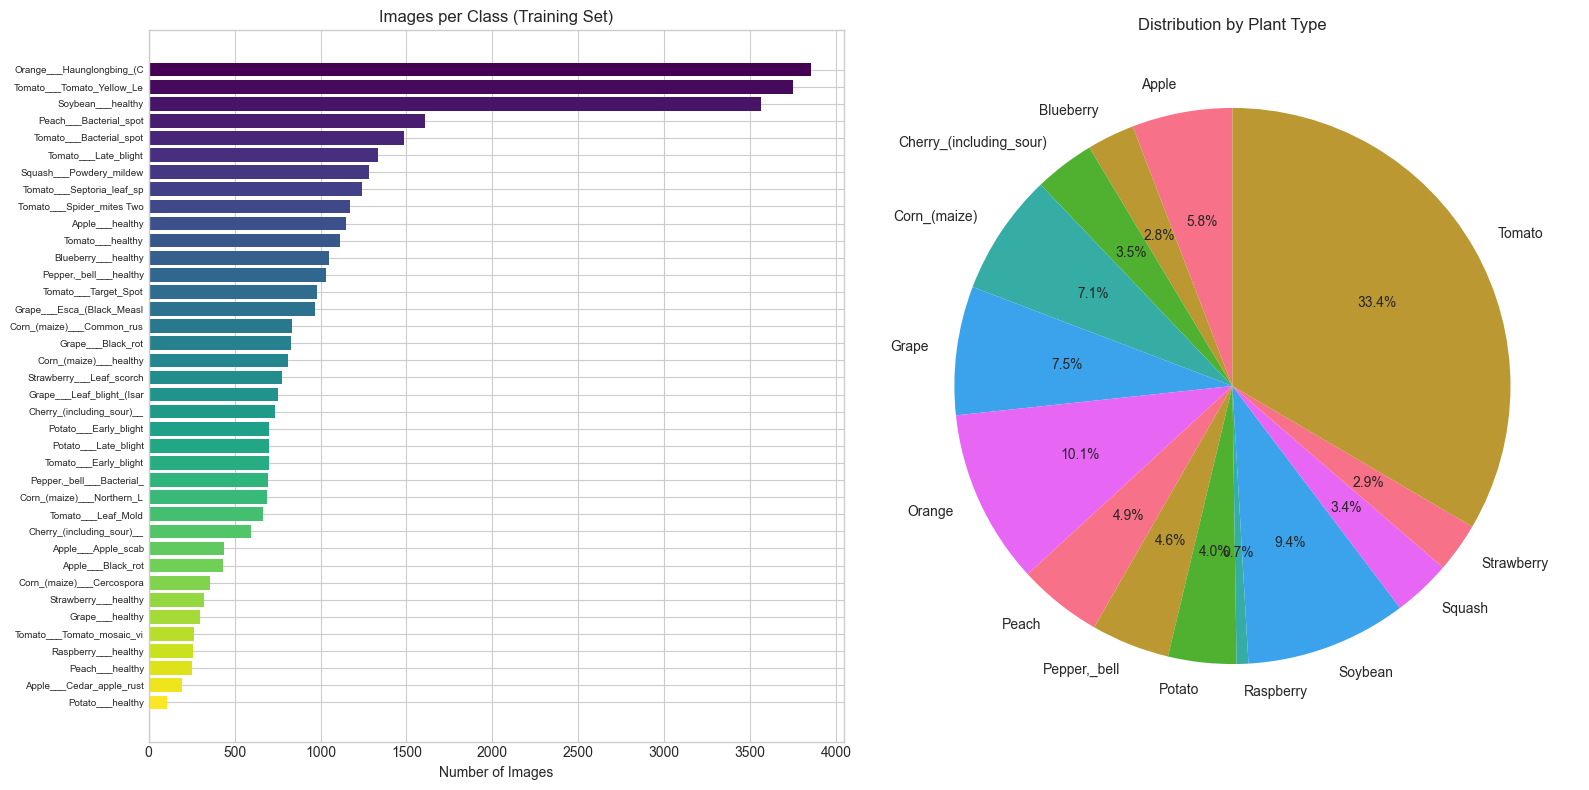

In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Class distribution bar chart
ax1 = axes[0]
df = pd.DataFrame([{'Class': k[:25], 'Count': v} for k, v in 
                   sorted(train_dist.items(), key=lambda x: x[1], reverse=True)])
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
ax1.barh(range(len(df)), df['Count'], color=colors)
ax1.set_yticks(range(len(df)))
ax1.set_yticklabels(df['Class'], fontsize=7)
ax1.set_xlabel('Number of Images')
ax1.set_title('Images per Class (Training Set)')
ax1.invert_yaxis()

# Plant type pie chart
ax2 = axes[1]
ax2.pie(list(plant_counts.values()), labels=list(plant_counts.keys()), 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution by Plant Type')

plt.tight_layout()
plt.show()

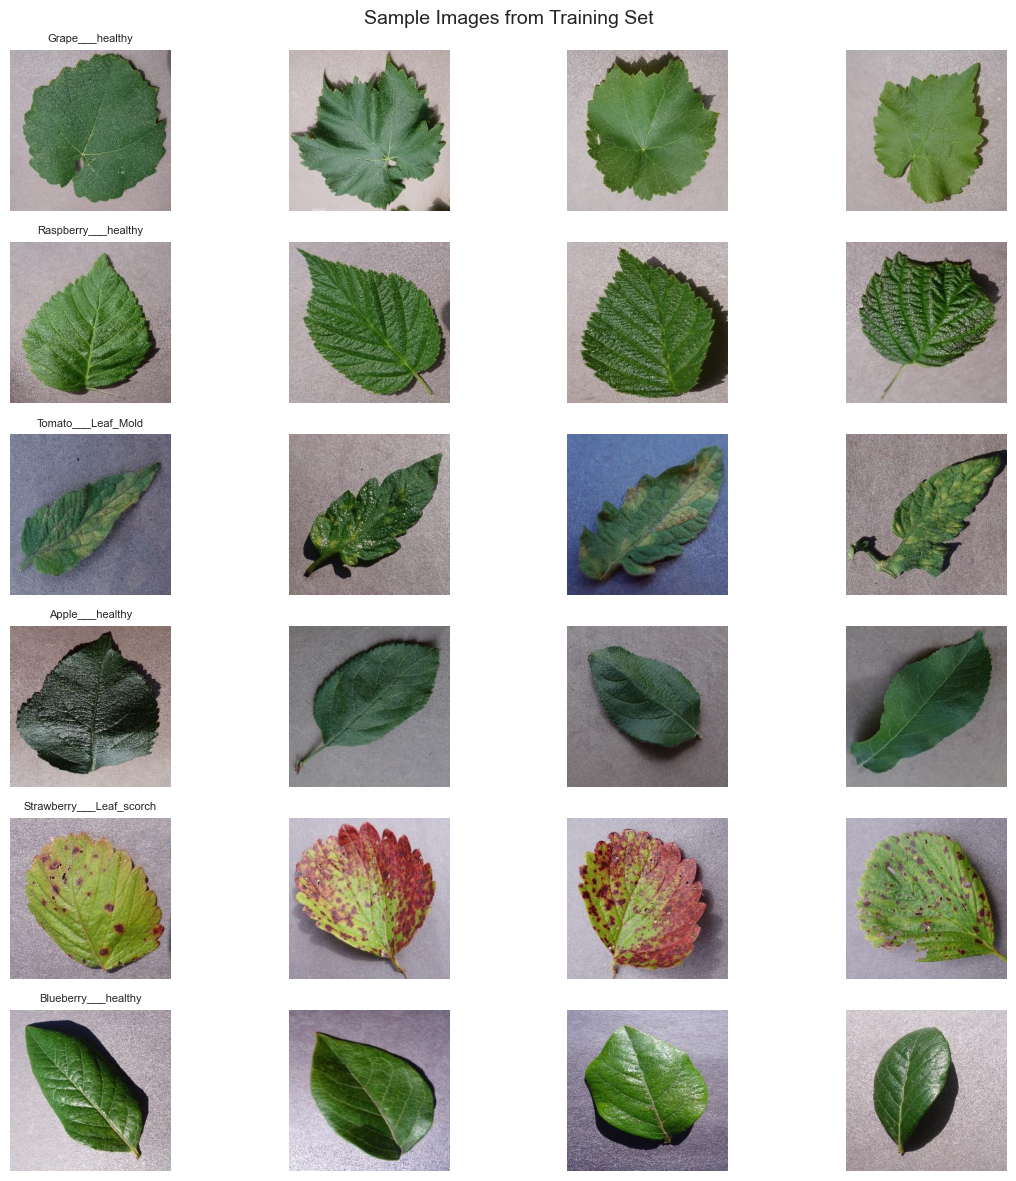

In [8]:
# Display sample images
def show_sample_images(data_dir: Path, n_classes: int = 6, n_samples: int = 4):
    """Display sample images from random classes."""
    classes = [d for d in data_dir.iterdir() if d.is_dir()]
    selected = random.sample(classes, min(n_classes, len(classes)))
    
    fig, axes = plt.subplots(n_classes, n_samples, figsize=(12, n_classes * 2))
    
    for i, class_dir in enumerate(selected):
        images = list(class_dir.glob('*'))[:n_samples]
        for j, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_dir.name[:30], fontsize=8)
    
    plt.suptitle('Sample Images from Training Set', fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(TRAIN_DIR)

## 5. Model Training with ResNet50

Create data generators with augmentation and train using transfer learning.

In [9]:
# Create data generators with augmentation
def create_data_generators(batch_size: int = BATCH_SIZE):
    """Create train, validation, and test data generators."""
    
    # Training generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2]
    )
    
    # Validation/Test generator - only rescale
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=RANDOM_SEED
    )
    
    val_gen = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen

# Create generators
train_gen, val_gen, test_gen = create_data_generators()

print(f"✅ Data generators created:")
print(f"   Training samples: {train_gen.samples}")
print(f"   Validation samples: {val_gen.samples}")
print(f"   Test samples: {test_gen.samples}")
print(f"   Number of classes: {train_gen.num_classes}")

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.
Found 8179 images belonging to 38 classes.
✅ Data generators created:
   Training samples: 37997
   Validation samples: 8129
   Test samples: 8179
   Number of classes: 38


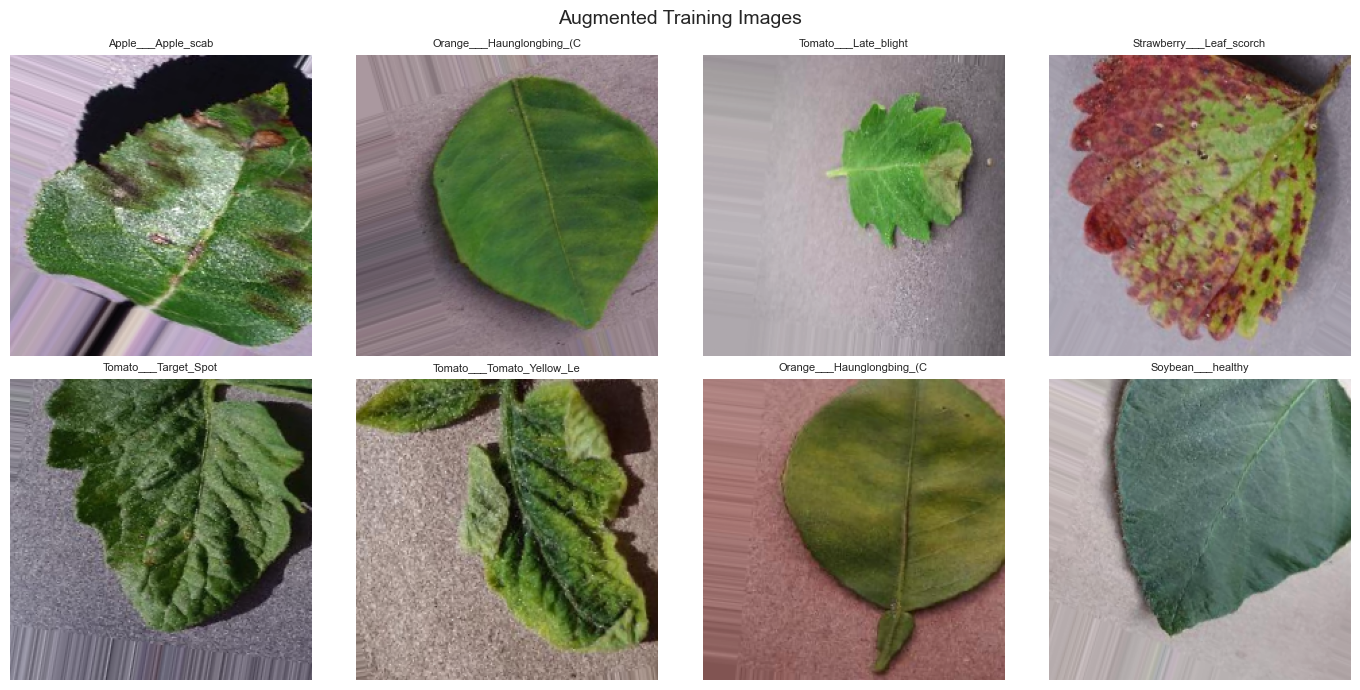

In [10]:
# Visualize augmented images
def show_augmented_images():
    """Display augmented training images."""
    images, labels = next(train_gen)
    class_indices = {v: k for k, v in train_gen.class_indices.items()}
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            class_idx = np.argmax(labels[i])
            ax.set_title(class_indices[class_idx][:25], fontsize=8)
        ax.axis('off')
    
    plt.suptitle('Augmented Training Images', fontsize=14)
    plt.tight_layout()
    plt.show()

show_augmented_images()

In [11]:
# Calculate class weights for imbalanced data
def calculate_class_weights(generator) -> Dict[int, float]:
    """Calculate class weights to handle class imbalance."""
    labels = generator.classes
    classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes=classes, y=labels)
    return dict(enumerate(weights))

class_weights = calculate_class_weights(train_gen)
print(f"✅ Class weights calculated for {len(class_weights)} classes")
print(f"   Min weight: {min(class_weights.values()):.3f}")
print(f"   Max weight: {max(class_weights.values()):.3f}")

✅ Class weights calculated for 38 classes
   Min weight: 0.259
   Max weight: 9.433


In [12]:
# Build ResNet50 model with transfer learning
def create_resnet50_model(num_classes: int, freeze_base: bool = True) -> Model:
    """Create ResNet50 transfer learning model."""
    
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    
    # Freeze base model
    base_model.trainable = not freeze_base
    
    # Build custom classification head
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Create model
num_classes = train_gen.num_classes
model = create_resnet50_model(num_classes, freeze_base=True)

# Compile
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print(f"🏗️ Model created with {num_classes} classes")
model.summary()

🏗️ Model created with 38 classes


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,786,086 (94.55 MB)

 Trainable params: 1,194,278 (4.56 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [13]:
# Setup callbacks
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'plant_disease_resnet50_best.keras'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


In [14]:
# ============================================
# PHASE 1: Train with frozen base model
# ============================================
print("🚀 PHASE 1: Training with frozen base model...")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print()

history1 = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n✅ Phase 1 training complete!")

🚀 PHASE 1: Training with frozen base model...
   Epochs: 30
   Batch size: 32
   Learning rate: 0.001

Epoch 1/30
  14/1188 ━━━━━━━━━━━━━━━━━━━━ 1:03:15 3s/step - accuracy: 0.0288 - loss: 3.7090

KeyboardInterrupt: 

In [ ]:
# ============================================
# PHASE 2: Fine-tune top layers (optional)
# ============================================
FINE_TUNE = True  # Set to False to skip fine-tuning
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LR = 1e-5

if FINE_TUNE:
    print("🔧 PHASE 2: Fine-tuning top layers...")
    
    # Unfreeze the top layers of the base model
    base_model = model.layers[1]  # Get the base model layer
    base_model.trainable = True
    
    # Freeze all layers except the last 30
    fine_tune_at = len(base_model.layers) - 30
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Print trainable status
    trainable_count = sum(1 for layer in model.layers if layer.trainable)
    print(f"   Trainable layers: {trainable_count}")
    print(f"   Fine-tune epochs: {FINE_TUNE_EPOCHS}")
    print(f"   Fine-tune learning rate: {FINE_TUNE_LR}")
    print()
    
    # Continue training
    history2 = model.fit(
        train_gen,
        epochs=EPOCHS + FINE_TUNE_EPOCHS,
        initial_epoch=history1.epoch[-1] + 1,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print("\n✅ Phase 2 fine-tuning complete!")
else:
    history2 = None
    print("⏭️ Skipping fine-tuning phase")

## 📊 Training Results Visualization

In [ ]:
# Combine training histories
def combine_histories(history1, history2):
    """Combine two training history objects."""
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key]
        if history2 is not None and key in history2.history:
            combined[key] = combined[key] + history2.history[key]
    return combined

history = combine_histories(history1, history2)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
if FINE_TUNE and history2 is not None:
    axes[0].axvline(x=len(history1.history['accuracy'])-1, color='gray', 
                    linestyle='--', label='Fine-tuning starts')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
if FINE_TUNE and history2 is not None:
    axes[1].axvline(x=len(history1.history['loss'])-1, color='gray', 
                    linestyle='--', label='Fine-tuning starts')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curves.png'), dpi=150)
plt.show()

# Print best metrics
best_val_acc = max(history['val_accuracy'])
best_epoch = history['val_accuracy'].index(best_val_acc) + 1
print(f"\n📈 Training Summary:")
print(f"   Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
print(f"   Final training accuracy: {history['accuracy'][-1]:.4f}")
print(f"   Final validation accuracy: {history['val_accuracy'][-1]:.4f}")

## 📋 Model Evaluation on Test Set

In [ ]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

print(f"📊 Test set: {test_gen.samples} images in {test_gen.num_classes} classes")

In [ ]:
# Evaluate on test set
print("🔄 Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Test Results:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

In [ ]:
# Get predictions and true labels
print("🔄 Generating predictions...")
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Get class names
class_names = list(test_gen.class_indices.keys())
index_to_class = {v: k for k, v in test_gen.class_indices.items()}

print(f"✅ Generated {len(y_pred)} predictions")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification Report
print("📋 Classification Report:")
print("=" * 80)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Save classification report
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)
print(f"✅ Classification report saved to {output_dir}/classification_report.txt")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix (smaller version for display)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=150)
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n📊 Per-Class Accuracy (Top 10 Lowest):")
print("-" * 50)
sorted_indices = np.argsort(per_class_accuracy)
for idx in sorted_indices[:10]:
    print(f"   {class_names[idx]}: {per_class_accuracy[idx]*100:.2f}%")

## 🔮 Sample Predictions

In [ ]:
# Visualize sample predictions
def show_predictions(test_gen, predictions, y_true, class_names, n_samples=12):
    """Display sample predictions with true and predicted labels."""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    # Get random indices
    indices = np.random.choice(len(y_true), n_samples, replace=False)
    
    test_gen.reset()
    all_images = []
    for batch in test_gen:
        all_images.extend(batch[0])
        if len(all_images) >= len(y_true):
            break
    all_images = np.array(all_images[:len(y_true)])
    
    for i, idx in enumerate(indices):
        img = all_images[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx]) * 100
        
        axes[i].imshow(img)
        is_correct = true_label == pred_label
        color = 'green' if is_correct else 'red'
        
        title = f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)"
        axes[i].set_title(title, fontsize=9, color=color)
        axes[i].axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'sample_predictions.png'), dpi=150)
    plt.show()

show_predictions(test_gen, predictions, y_true, class_names)

## 💾 Save Model and Artifacts

In [ ]:
# Save the final model
model_filename = f"plant_disease_{MODEL_NAME}_final.keras"
model_path = os.path.join(output_dir, model_filename)
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# Save class indices mapping
import json

class_indices_path = os.path.join(output_dir, 'class_indices.json')
with open(class_indices_path, 'w') as f:
    json.dump(train_gen.class_indices, f, indent=2)
print(f"✅ Class indices saved to: {class_indices_path}")

index_to_class_path = os.path.join(output_dir, 'index_to_class.json')
with open(index_to_class_path, 'w') as f:
    json.dump(index_to_class, f, indent=2)
print(f"✅ Index to class mapping saved to: {index_to_class_path}")

# Save training history
history_df = pd.DataFrame(history)
history_path = os.path.join(output_dir, 'training_history.csv')
history_df.to_csv(history_path, index=False)
print(f"✅ Training history saved to: {history_path}")

# Print summary of saved files
print(f"\n📁 All artifacts saved to: {output_dir}")
print("   Files:")
for f in os.listdir(output_dir):
    print(f"     - {f}")

In [ ]:
# If running on Colab with Google Drive, copy model to Drive
if IS_COLAB and os.path.exists('/content/drive/MyDrive'):
    drive_output = '/content/drive/MyDrive/plant_disease_model'
    os.makedirs(drive_output, exist_ok=True)
    
    import shutil
    for f in os.listdir(output_dir):
        src = os.path.join(output_dir, f)
        dst = os.path.join(drive_output, f)
        shutil.copy2(src, dst)
    
    print(f"✅ All files copied to Google Drive: {drive_output}")
else:
    print("💡 To persist the model, download the files or mount Google Drive")

## 🧪 Test Single Image Prediction

In [ ]:
def predict_image(image_path, model, class_names, img_size=224):
    """Make prediction on a single image."""
    from tensorflow.keras.preprocessing import image as keras_image
    
    # Load and preprocess image
    img = keras_image.load_img(image_path, target_size=(img_size, img_size))
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    # Get top 5 predictions
    top5_indices = np.argsort(predictions[0])[-5:][::-1]
    top5 = [(class_names[i], predictions[0][i]) for i in top5_indices]
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'top5': top5,
        'image': img
    }

# Test with a random image from test set
import random
test_classes = os.listdir(test_dir)
random_class = random.choice(test_classes)
class_path = os.path.join(test_dir, random_class)
random_image = random.choice(os.listdir(class_path))
test_image_path = os.path.join(class_path, random_image)

# Make prediction
result = predict_image(test_image_path, model, class_names)

# Display
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(result['image'])
ax.set_title(f"True: {random_class}\nPredicted: {result['predicted_class']} ({result['confidence']*100:.1f}%)", 
             fontsize=12)
ax.axis('off')
plt.show()

print("\n📊 Top 5 Predictions:")
for i, (cls, conf) in enumerate(result['top5'], 1):
    print(f"   {i}. {cls}: {conf*100:.2f}%")

## 📤 Download Model (Colab only)

Run the cell below to download the trained model and artifacts to your local machine.

In [ ]:
# Download model files (Colab only)
if IS_COLAB:
    from google.colab import files
    import zipfile
    
    # Create a zip file of all outputs
    zip_path = '/content/plant_disease_model.zip'
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, file_list in os.walk(output_dir):
            for file in file_list:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)
    
    print(f"📦 Created zip file: {zip_path}")
    print("📥 Starting download...")
    files.download(zip_path)
else:
    print("💡 This cell is for Google Colab downloads only")
    print(f"   Your files are saved at: {output_dir}")

---

## 🎉 Training Complete!

**Summary:**
- Model architecture: ResNet50 with transfer learning
- Dataset: PlantVillage (38 plant disease classes)
- Training phases:
  1. Feature extraction (frozen base)
  2. Fine-tuning (top layers unfrozen)

**Artifacts saved:**
- `plant_disease_resnet50_final.keras` - Final trained model
- `class_indices.json` - Class name to index mapping
- `index_to_class.json` - Index to class name mapping
- `training_history.csv` - Training metrics per epoch
- `training_curves.png` - Accuracy/loss visualization
- `confusion_matrix.png` - Confusion matrix heatmap
- `classification_report.txt` - Per-class metrics

**Next Steps:**
1. Download the model files
2. Copy `plant_disease_resnet50_final.keras` to your `models/` directory
3. Copy the JSON files to your `data/` directory
4. Run the API: `python src/api.py`
5. Run the UI: `streamlit run src/ui_app.py`